## Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import json
from matplotlib import dates as plt_dates

In [2]:
import numpy as np

## Exercice 1: Ingestion and Processing

### Ex 1.1: Exploration

Let's begin by summarising and understanding the data we are analysing. All the data we have is located in the `donnees` folder. Inside, we find the following:

- `images`: A folder containing pictures found on the Internet, purporting to be real pictures.
- `articles_web.txt`: Articles.
- `facebook_posts.json`: Facebook posts.
- `metadata_comptes.json`: Informations about X (Twitter) accounts.
- `relations_network.csv`: Interactions between X (Twitter) accounts.
- `textes_analyse_sentiment.txt`: A collection of texts, apparently reactions to articles or tweets.
- `tweets_dataset.csv`: A CSV listing tweets.

We will now explore, one by one, some of those files.

#### articles_web.txt

Looking at the file, it is formatted in a specific way. This will allow us later to load it into a data structure that’s more convenient to work with.

```
========================================
ARTICLE {n} - Source: {website}
Date: {date_w3c}
Auteur: {author}
========================================

{title}

{content}
```

In [3]:
list_articles = []
with open('donnees/articles_web.txt', 'r') as f:
    lines = f.readlines()
for article in ''.join(lines).split('========================================\nARTICLE '):
    if '' != article:
        
        (source, source_leftover) = article[12:].split('\nDate: ')
        (date, date_leftover) = source_leftover.split('\nAuteur: ')
        (author, author_leftover) = date_leftover.split('\n========================================\n\n')
        content = author_leftover[:-1]
        
        list_articles.append([source, author, date, content, pd.NA]) # NA because no engagement available for articles

df_articles = pd.DataFrame(list_articles, columns=['platform', 'author', 'date', 'content', 'engagement'])
df_articles['date'] = pd.to_datetime(df_articles['date'])
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   platform    4 non-null      object        
 1   author      4 non-null      object        
 2   date        4 non-null      datetime64[ns]
 3   content     4 non-null      object        
 4   engagement  0 non-null      object        
dtypes: datetime64[ns](1), object(4)
memory usage: 292.0+ bytes


#### facebook_posts.json

In [4]:
fb_posts_df = pd.read_json('donnees/facebook_posts.json', convert_dates=['post_date'])
fb_posts_df.sort_values('post_date', inplace=True) # We sort by date
fb_posts_df['engagement'] = fb_posts_df['likes'] + fb_posts_df['shares'] + fb_posts_df['comments']
fb_posts_df.describe()

,post_date,likes,shares,comments,engagement
count,41,41.000000,41.000000,41.000000,41.000000
mean,2024-01-17 22:32:03.926829312,2831.317073,1509.341463,725.414634,5066.073171
min,2024-01-15 09:30:12,234.000000,67.000000,45.000000,357.000000
25%,2024-01-16 15:45:29,678.000000,234.000000,234.000000,1101.000000
50%,2024-01-18 09:00:15,2456.000000,1234.000000,567.000000,4257.000000
75%,2024-01-18 22:15:07,4523.000000,2567.000000,1123.000000,8633.000000
max,2024-01-19 22:00:08,8765.000000,5432.000000,2345.000000,16542.000000
std,NaN,2205.581969,1357.147848,613.381609,4125.600601


In [5]:
fb_posts_df.iloc[0]

page_name                        Collectif Anti-Éoliennes Loire
post_date                                   2024-01-15 09:30:12
content       RASSEMBLEMENT URGENT ! Les autorités veulent n...
likes                                                      2340
shares                                                      876
comments                                                    234
engagement                                                 3450
Name: 0, dtype: object

In [6]:
fb_posts_df.iloc[0]['content']

"RASSEMBLEMENT URGENT ! Les autorités veulent nous imposer 150 monstres d'acier qui vont détruire notre patrimoine maritime. Rejoignez-nous samedi 10h place de la Mairie. Ensemble, nous sommes plus forts ! ✊🌊 #StopEoliennes #Loire"

#### tweets_dataset.csv

In [7]:
x_posts_df = pd.read_csv('donnees/tweets_dataset.csv', parse_dates=['date'])
x_posts_df['interactions'] = x_posts_df['retweets'] + x_posts_df['likes']
x_posts_df.head(3)

,username,text,date,retweets,likes,hashtags,mentions,interactions
0,Dr_Laurent_CNRS,Nos études sur l'impact des éoliennes offshore...,2024-01-15 09:23:12,45,187,#EolienOffshore;#Recherche,NaN,232
1,EcoDefense44,URGENT ! Les éoliennes vont détruire notre lit...,2024-01-15 14:32:45,12,34,#NonAuxEoliennes;#SauverLaLoire,NaN,46
2,Sophie_Journaliste,Interview du préfet maritime sur le projet éol...,2024-01-15 16:47:33,23,78,#Journalisme;#Loire,NaN,101


In [8]:
# All the posts are in 2024
x_posts_df.describe()

,date,retweets,likes,interactions
count,95,95.000000,95.000000,95.000000
mean,2024-01-18 15:10:32.905262848,98.968421,292.200000,391.168421
min,2024-01-15 09:23:12,3.000000,7.000000,10.000000
25%,2024-01-17 03:00:14.500000,34.000000,96.500000,132.000000
50%,2024-01-18 16:12:31,76.000000,234.000000,310.000000
75%,2024-01-19 23:04:16,167.000000,495.000000,662.000000
max,2024-01-21 13:26:37,245.000000,723.000000,968.000000
std,NaN,72.813731,216.246343,288.934273


#### metadata_comptes.json

In [9]:
with open('donnees/metadata_comptes.json') as f:
    data = json.load(f)

x_accounts_df = pd.DataFrame(data['twitter_accounts'])
x_accounts_df['created_date'] = pd.to_datetime(x_accounts_df['created_date'])
x_accounts_df.head(3)

,username,created_date,followers_count,following_count,total_tweets,bio,location,profile_image_url,website
0,Dr_Laurent_CNRS,2011-03-15,4523,1876,8934,Biologiste marin | CNRS La Rochelle | Recherch...,"La Rochelle, France",https://example.com/profiles/dr_laurent.jpg,https://www.cnrs.fr/fr/personne/laurent-bernard
1,AlerteVerite2024,2023-12-05,3421,4567,456,Révéler la vérité cachée | Contre les lobbies ...,France,https://example.com/profiles/alerteverite.jpg,https://verite-citoyenne-info.net
2,Sophie_Journaliste,2014-06-20,18934,2345,12456,Journaliste d'investigation @OuestFrance | Env...,"Nantes, France",https://example.com/profiles/sophie_martin.jpg,https://www.ouest-france.fr/auteur/sophie-martin


### Ex 1.2: Creation of a unified DataFrame

On ne créé pas de colonne `content_type`, ce n’est pas nécessaire car l’information est déjà dans `platform`.

In [10]:
posts_df_1 = fb_posts_df.drop(columns=['likes', 'shares', 'comments']).rename(columns={'page_name': 'author', 'post_date': 'date'})
posts_df_1.insert(loc=0, column='platform', value='facebook')
posts_df_2 = x_posts_df.drop(columns=['hashtags', 'likes', 'mentions', 'retweets']).rename(columns={
    'text': 'content',
    'username': 'author'
})
posts_df_2.insert(loc=0, column='platform', value='x')

posts_df = pd.concat([posts_df_1, posts_df_2, df_articles]).sort_values(by='date')

posts_df

/tmp/ipykernel_736/3584353811.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  posts_df = pd.concat([posts_df_1, posts_df_2, df_articles]).sort_values(by='date')


,platform,author,date,content,engagement,interactions
0,x,Dr_Laurent_CNRS,2024-01-15 09:23:12,Nos études sur l'impact des éoliennes offshore...,NaN,232.0
0,facebook,Collectif Anti-Éoliennes Loire,2024-01-15 09:30:12,RASSEMBLEMENT URGENT ! Les autorités veulent n...,3450.0,NaN
1,facebook,Vérité Énergie France,2024-01-15 14:22:45,🚨 SCANDALE 🚨\n\nNous avons obtenu des document...,8911.0,NaN
1,x,EcoDefense44,2024-01-15 14:32:45,URGENT ! Les éoliennes vont détruire notre lit...,NaN,46.0
2,facebook,Transition Énergétique Pays de la Loire,2024-01-15 16:15:33,Point factuel sur le projet de parc éolien off...,446.0,NaN
...,...,...,...,...,...,...
90,x,FinalResistance,2024-01-21 09:35:46,C'est l'ULTIME COMBAT décisif pour notre liber...,NaN,778.0
91,x,ElodieC_Biologiste,2024-01-21 10:27:31,Biologiste marine docteure. J'ai personnelleme...,NaN,208.0
92,x,VraieCommunaute,2024-01-21 11:19:08,Rejoignez dès maintenant notre grande communau...,NaN,668.0
93,x,ThierryB_Retraite,2024-01-21 12:04:52,Retraité EDF après 40 longues années de carriè...,NaN,132.0


In [11]:
posts_df.to_csv('dataset_unifie.csv')

### Ex 1.3: Temporal Analysis

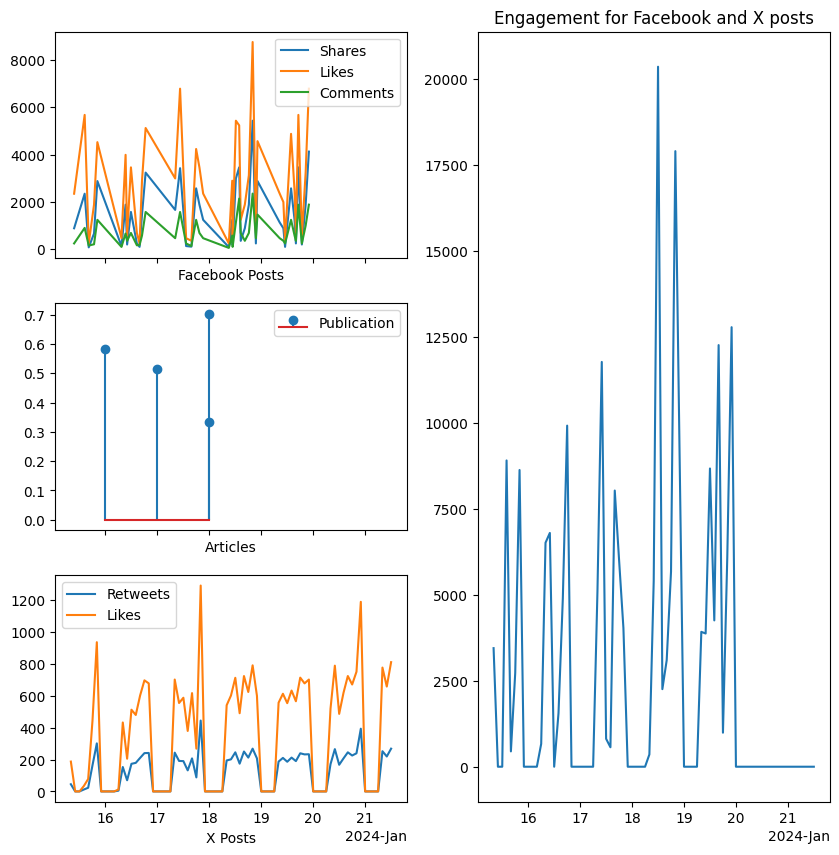

In [12]:
fig = plt.figure(figsize=(10, 10))
# sub_fig, (ax_fb, ax_x) = plt.subplots(2, 1, sharex=True)

ax_x = fig.add_subplot(3, 2, 5)
# On groupe par 2h pour que ce soit plus lisible et facile à comprendre
ax_x_df = x_posts_df.set_index('date').groupby(pd.Grouper(freq='2h')).sum()
ax_x.plot(ax_x_df.index, ax_x_df['retweets'], label="Retweets")
ax_x.plot(ax_x_df.index, ax_x_df['likes'], label="Likes")
ax_x.legend()
ax_x.set_xlabel("X Posts")
ax_x.xaxis.set_major_formatter(plt_dates.ConciseDateFormatter(ax_x.xaxis.get_major_locator()))

ax_fb = fig.add_subplot(3, 2, 1, sharex=ax_x)
ax_fb.plot(fb_posts_df['post_date'], fb_posts_df['shares'], label="Shares")
ax_fb.plot(fb_posts_df['post_date'], fb_posts_df['likes'], label="Likes")
ax_fb.plot(fb_posts_df['post_date'], fb_posts_df['comments'], label="Comments")
ax_fb.set_xlabel("Facebook Posts")
ax_fb.legend()
ax_fb.tick_params(labelbottom=False)

ax_arts = fig.add_subplot(3, 2, 3, sharex=ax_x)
ax_arts.stem(df_articles['date'], np.random.rand(len(df_articles)), label="Publication")
ax_arts.set_xlabel("Articles")
ax_arts.legend()
ax_arts.tick_params(labelbottom=False)

ax_unified = fig.add_subplot(1, 2, 2)
# Idem (on groupe par deux heures)
df_fb_x = posts_df.set_index('date').groupby(pd.Grouper(freq='2h')).sum()
ax_unified.plot(df_fb_x.index, df_fb_x['engagement'])
ax_unified.set_title('Engagement for Facebook and X posts')
ax_unified.xaxis.set_major_formatter(plt_dates.ConciseDateFormatter(ax_unified.xaxis.get_major_locator()))

Nous observons une relation quasi linéaire entre le nombre de partages, de mentions “j’aime” et de commentaires, ce qui semble fortement indicatif d’un comportement de type CIB.
Les articles en question ont tous étés publiés entre le 16 et le 18 janvier, ce qui ne nous permet pas d’aboutir à une conclusion particulière, étant donné qu’il n’y a que 4 articles dans le corpus.

In [13]:
fb_n_posts = fb_posts_df.set_index('post_date').groupby(pd.Grouper(freq='D')).count()
# La création de comptes remonte à beaucoup plus long, on est obligé de se limiter
x_n_accounts = x_accounts_df[x_accounts_df['created_date'] > '2023-11-01'].set_index('created_date').groupby(pd.Grouper(freq='3D')).count()
x_n_posts_df = x_posts_df.set_index('date').groupby(pd.Grouper(freq='D')).count()
df_n_articles = df_articles.set_index('date').groupby(pd.Grouper(freq='D')).count()

#.groupby(by='post_date').count()

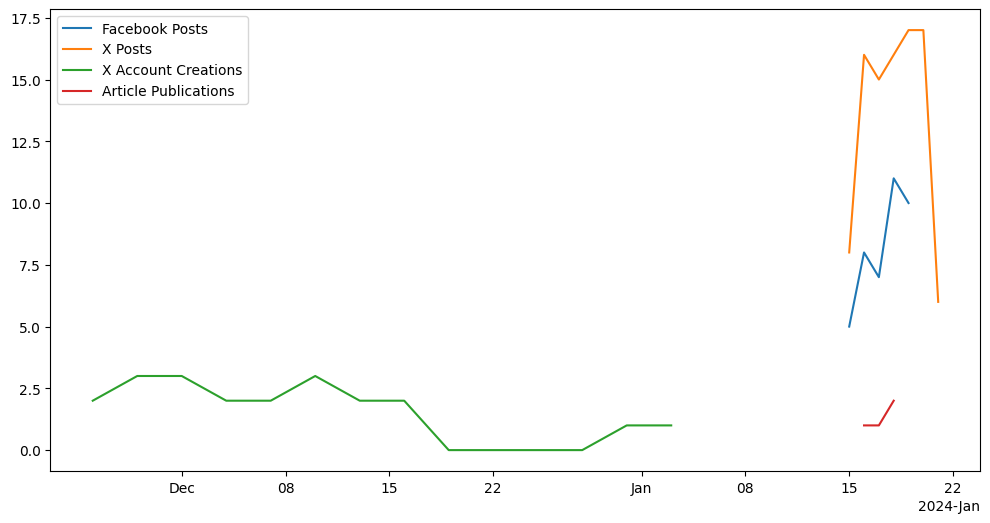

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fb_n_posts.index, fb_n_posts['content'])
ax.plot(x_n_posts_df.index, x_n_posts_df['likes'])
ax.plot(x_n_accounts.index, x_n_accounts['bio'])
ax.plot(df_n_articles.index, df_n_articles['content'])
ax.legend(['Facebook Posts', 'X Posts', 'X Account Creations', 'Article Publications'])
ax.xaxis.set_major_formatter(plt_dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

La visualisation suggère une corrélation entre les publications sur X et sur Facebook et sur les articles, mais les données sont trop clairsemées pour permettre de tirer des conclusions définitives, d’autant plus que la période d’observation est très courte (quelques jours seulement).
La création de comptes quant à elle ne laisse rien suggérer d’anormal, elle s’étand de manière plus ou moins régulière avant de s’arrêter début janvier.

### Questions d’analyse

1. *Quelle plateforme présente le volume d'activité le plus important ?*

Il y a plus de posts sur Twitter/X (95 posts contre 41 posts Facebook). En revanche, il y a beaucoup plus d’activité sur les posts Facebook.

2. *Identifiez-vous des pics d'activité synchronisés entre plateformes ? (indicateur de campagne
coordonnée)*

Pas vraiment, en tout cas pas dans une échelle de 15-30 minutes. Mais le dataset est trop limité pour qu’on comprenne.

3. *Quel est le ratio engagement/publication moyen par plateforme ?*

En moyenne, 5066 likes par post Facebook et 391 interactions par tweet X.